# Fixes need to do:
## we need to fix the vanishing calcaulations in the nets, maybe amplifying all the values by some factor (100 maybe to get to normal values) and in the end we can just shrink the result (only the output) in the real test

## Add the normalization (around 0) of the the outputs - if the nets doesn't do it naturally

## Maybe initialize the weights to a big number because all the values are very small

## Add the scipy snippet to resample the vectors to be the same vector (DONE)

## MAYBE change the fully connected layers to go from each cell to an output instead of merging all the outputs to a big vector and forwarding it through a big FC

# Libraries Imports

In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import os
import string 
# from google.colab import drive
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
import time
import matplotlib.pyplot as plt
import pandas as pd
import os
from data import *

checking for device (GPU)

In [2]:
# drive.mount('/content/drive')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('training on: ',device)


training on:  cuda


# Data Saving and Loading

In [3]:
def save_model_with_checkpoint(model, lr, model_type='spectra'):
    if model.with_drop == True:
        model_path = f'/home/drors/project/Models/{model_type.lower()}_drop_{model.drop}_lr_{lr}.net'
    else:
        model_path = f'/home/drors/project/Models/{model_type.lower()}_without_lr_{lr}.net'

    if model_type.lower() == 'spectra':
        checkpoint = {'with_drop': model.with_drop,
                      'hidden_size': model.hidden_size,
                      'n_layers': model.n_layers,
                      'drop': model.drop,
                      'wave_amount': model.wave_amount,
                      'seq_size': model.seq_size,
                      'output_amount':model.output_amount,
                      'seq_amount': model.seq_amount,
                      'state_dict': model.state_dict()}
    elif model_type.lower() == 'doppler':
        checkpoint = {'method': model.method,
                      'with_drop': model.with_drop,
                      'hidden_size': model.hidden_size,
                      'n_layers': model.n_layers,
                      'drop': model.drop,
                      'wave_amount_sample': model.wave_amount_sample,
                      'wave_amount_predict': model.wave_amount_predict,
                      'seq_size': model.seq_size,
                      'obs_amount':model.obs_amount,
                      'combine_wave_input': model.combine_wave_input,
                      'batch_size': model.batch_size,
                      'state_dict': model.state_dict()}
        
    with open(model_path, 'wb') as f:
        torch.save(checkpoint, f)

In [34]:
def load_model_from_file(file_name: str):
    with open(file_name, 'rb') as f:
        checkpoint = torch.load(f)
    
    if 'spectra' in file_name:
        
        loaded_model = SpectraNet(checkpoint['with_drop'],
                               checkpoint['hidden_size'],
                               checkpoint['n_layers'],
                               checkpoint['drop'],
                               20,
                               checkpoint['wave_amount'],
                               checkpoint['seq_size'],
                               checkpoint['output_amount'],
                               checkpoint['seq_amount'])
    elif 'doppler' in file_name:
        loaded_model = DopplerNet(checkpoint['method'],
                                  checkpoint['with_drop'],
                                  checkpoint['hidden_size'],
                                  checkpoint['n_layers'],
                                  checkpoint['drop'], 
                                  checkpoint['batch_size'],
                                  checkpoint['wave_amount_sample'],
                                  checkpoint['wave_amount_predict'],
                                  checkpoint['seq_size'],
                                  checkpoint['obs_amount'],
                                  checkpoint['combine_wave_input'])
        
    loaded_model.load_state_dict(checkpoint['state_dict'])
    return loaded_model

In [37]:
def load_model_from_mode(model_type: str, with_drop, drop: float, lr: float):
#     try:
    if with_drop:
        return load_model_from_file(f'/home/drors/project/Models/{model_type.lower()}_drop_{drop}_lr_{lr}.net')
    else:
        return load_model_from_file(f'/home/drors/project/Models/{model_type.lower()}_without_lr_{lr}.net')
#     except:
#         print("no such file exist, if entered with drop try and put a different drop value")

# Data Pre-Processing

In [6]:
def get_sizes(train, test, val):
    iterator = iter(train)
    it1 = next(iterator)
    obs, ground_truth, sys_id, times, velocities = it1
    print(obs.shape, obs.type()) # observations: Obs_amount X wave_amount
    print(ground_truth.shape, ground_truth.type()) # Ground Truth Spectras: stars_amount (2) X wave_output_amount
    print(sys_id) # System ID: int
    print(times.shape, times.type()) # Time of sample: Obs_amount
    print(velocities.shape, velocities.type()) # Velocities per sample time: stars_amount (2) X Obs_amount
    Obs_amount, wave_amount, wave_output = obs.shape[0], obs.shape[1], ground_truth.shape[1]
    return Obs_amount, wave_amount, wave_output

In [7]:
def find_closest_round_and_div(num: int, divider: int):
    '''
    In our use-case the divider will be the sequnce length and we will try to find the closest mult of it to the
    num (number) we get in the function, which is the orginal length of the vectors.
    '''
    div = num // divider
    num_new = div*divider
    num_plus = (div+1)*divider
    print(num_new, num, num_plus)
    if num - num_new < num_plus - num:
        return num_new, div
    else:
        return num_plus, div

## Data Hyper-Parameters

Remember to change all the tensors to Float (easier than changing all the parameters of the net to double, and space effective)

In [8]:
# dataset = SpectraDataset()
train_loader, test_loader, val_loader, std_dict = getLoader(seed=1)

In [9]:
print(std_dict)

{'min source': 4992.544013409346, 'max source': 5087.104146943163, 'min target': 4990.122000000003, 'max target': 5079.972000001964, 'source len': 7500, 'target len': 1700, 'vector source': array([4992.54401341, 4992.55662311, 4992.56923281, ..., 5087.07892754,
       5087.09153724, 5087.10414694]), 'vector target': array([4990.122     , 4990.17488405, 4990.2277681 , ..., 5079.8662319 ,
       5079.91911595, 5079.972     ])}


In [10]:
observation_amount, wave_values, wave_output = get_sizes(train_loader, test_loader, val_loader)
print(observation_amount, wave_values, wave_output)
#observation_amount The amount of time point we observe the star, it's also the length of the output speed vector 
# observation_amount is the batch size in the spectra net
batch_size = 20 # batch size is the batch size of the doppler net because there we calculate each velocity at a certian time point, independently of the other (so we can also mix the systems together)
# wave_values_amount = 7651 # need to check the file
# wave_output_amount = 1995 # need to check the file
wave_sequence_length = 500
output_wave_sequence_length = 170
doppler_sequence_length12 = 100
doppler_sequence_length25 = 400
truncated_length, wave_seq_amount = find_closest_round_and_div(wave_values, wave_sequence_length) #7500
new_wave_output, gt_seq_amount = find_closest_round_and_div(wave_output, output_wave_sequence_length) #1700
concat_value_output, concat_seq_amount = find_closest_round_and_div(truncated_length+new_wave_output,
                                                                   doppler_sequence_length25)
'''the output spectra should be the same length (be structured from the same wave length) as the input'''
hidden_size = wave_sequence_length # we keep the hidden size the same as seq_length so we won't have to change
hidden_size_doppler = doppler_sequence_length25
# the input size of the FullyConnected #200 #might change
num_layers_spectra = 2
num_layers_doppler = 2
drop_spectra = 0.5
drop_doppler = 0.5
# embedding_spectra = 100 # we embedd the number (the amplitude of the wave) to a vector so we can perform proparate matrix mult
# embedding_doppler = 100 # we embedd the number (the amplitude of the wave) to a vector so we can perform proparate matrix mult

torch.Size([20, 7500]) torch.FloatTensor
torch.Size([2, 1700]) torch.FloatTensor
55
torch.Size([20]) torch.FloatTensor
torch.Size([2, 20]) torch.FloatTensor
20 7500 1700
7500 7500 8000
1700 1700 1870
9200 9200 9600


## Data Hendling
We don't have a lot of different stars to work with, we ahve a lot of data on their systems (20 observations, like in real life) but not a lot of different systems. so we will work with 1 batch size probably. but the observation amount will act as the inner net batch size - meaning we will work on all the 20 observations simultaniously and then average them out to get on single solution - spectra vector  

In [11]:
def split_vector_to_seqs(wave_tensor, seq_length:int = wave_sequence_length,
                         seq_amount=wave_seq_amount, new_length=truncated_length):
    '''
    wave_vector: a 2-D torch.tensor of shape: obs_amount X wave_samples,
    so in the end for each system we have data that looks like:
    obs_amount X seq_amount X seq_length
    
    to save calculations we calculate the new lengths in the __init__ of the model
    '''
#     sequences_amount = wave_tensor.size()[-1] // seq_length
#     new_length = sequences_amount * seq_length
    # print(f'length of data: {len(data)} sequences amount: {sequences_amount} ')
    if new_length > wave_tensor.shape[1]:
        zero_pad = torch.zeros(wave_tensor.shape[0], new_length-wave_tensor.shape[1])
        wave_tensor = torch.cat((wave_tensor, zero_pad), 1)
    else:
        wave_tensor = wave_tensor[:, :new_length] #truncating the last not complete seq
    # print(f'length of new data: {len(data)}') 
    wave_tensor = wave_tensor.view(-1, seq_amount, seq_length)
#     print(f'in function: {wave_tensor.size()}')
    return wave_tensor

def combine_seqs_to_vector(wave_splitted_tensor, new_length=truncated_length):
    '''
    the input is from the shape: obs_amount X seq_amount X seq_length
    output will be a 2-D tensor that combines seq_amountXseq_length to one vector
    '''
#     new_length = truncated_length
#    wave_splitted_tensor = wave_splitted_tensor.reshape(-1, new_length) # 20 - batch size
    wave_splitted_tensor = wave_splitted_tensor.reshape(20,-1) # 20 - batch size
#     print(f'in function: {wave_splitted_tensor.size()}')
    return wave_splitted_tensor
    

# Model Class Template

In [12]:
class SpectraNet(nn.Module):
    def __init__(self, with_drop=True, hidden_size=hidden_size, n_layers=num_layers_spectra, drop=drop_spectra, 
                 batch_size=observation_amount, wave_amount=truncated_length, seq_size=wave_sequence_length, 
                 output_amount=wave_output, seq_amount=wave_seq_amount):
        super(SpectraNet, self).__init__()
        self.with_drop = with_drop
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.drop = drop
        self.batch_size = batch_size
        self.wave_amount = wave_amount
        self.output_amount = output_amount
        self.seq_size = seq_size
        self.seq_amount = seq_amount
        self.hidden_layer_size = int(self.wave_amount/2)
        self.conv1 = nn.Sequential(nn.Conv2d(1,4, kernel_size = 5, stride = 2),
                                   nn.ReLU()) # 1*1*20*15000 -> 1*4*8*7498
        self.conv2 = nn.Sequential(nn.Conv2d(4,8, kernel_size = 5, stride = 2),
                                   nn.ReLU(),
                                   nn.AvgPool2d(kernel_size = (1,4))) #1*4*8*7498 -> 1*8*2*3747/2
        self.convfc = nn.Sequential(nn.Linear(14976,8000),
                                    nn.ReLU(),
                                    nn.Dropout(drop))
        self.convfc1 = nn.Linear(8000, self.output_amount)
        self.convfc2 = nn.Linear(8000 + self.output_amount, self.output_amount)
        if with_drop == True:
            self.rnn = nn.LSTM(self.seq_size, hidden_size, n_layers,
                               dropout=drop, batch_first=True, bidirectional=True)
            self.attention = nn.MultiheadAttention(seq_size, num_heads=1, dropout=drop)
            self.dropout = nn.Dropout(drop)
            '''should take the whole RNN outpur vector (concatanate the outputs from each lstm-cell-forward_pass) and feed it to one FC'''
            self.fc1 = nn.Sequential(nn.Linear(self.wave_amount, self.hidden_layer_size),
                                    nn.ReLU(),
                                    self.dropout,
                                    nn.Linear(self.hidden_layer_size, self.output_amount))
            self.fc2 = nn.Linear(self.output_amount, self.output_amount)

        else:
            self.rnn = nn.LSTM(self.seq_size, hidden_size, n_layers,
                                   batch_first=True, bidirectional=True)
            self.attention = nn.MultiheadAttention(seq_size, num_heads=1)
            self.fc1 = nn.Sequential(nn.Linear(self.wave_amount, self.hidden_layer_size),
                                    nn.SiLU(),
                                    nn.Linear(self.hidden_layer_size, self.output_amount))
            self.fc2 = nn.Linear(self.output_amount, self.output_amount)
    
        #ADD THE ATTENTION METHOD.
        
    def forward(self, spectra, hidden, method: int = 3):
        '''     
        1. sum the losses of each spectra and then backprop - I think it will backprop in the net twice
        (for each spectra)
        2. train the first layers until spectra1 and then only the last FC on the spectra2 with all the
        others params grad's are off
        '''
        if self.with_drop: 
            spectra = self.dropout(spectra)
        spectra, hidden = self.rnn(spectra, hidden)
#         print(f'spectra dimensions: {spectra.size()}')
        if self.with_drop:
            spectra = self.dropout(spectra) #, self.dropout(small_spectra)
#         print(f'spectra dimensions: {spectra.size()}')# hidden dimensions {hidden[0].size()} state dimesions: {hidden[1].size()}')
#        print(spectra.shape)
#        spectra = (spectra[:,:,:self.hidden_size] + spectra[:,:,-self.hidden_size:])/2 #average over the two directions.
        '''To give the attention input we need to view it in: seq_amount X batch_size X seq_length'''
#         ##spectra = spectra.reshape(self.seq_amount, self.batch_size, self.seq_size)
#         ##spectra, _ = self.attention(spectra, spectra, spectra, need_weights=False)
#         ##spectra = spectra.reshape(self.batch_size, self.seq_amount, self.seq_size)
        spectra = combine_seqs_to_vector(spectra.contiguous(), self.wave_amount)
#         print(f'spectra dimensions: {spectra.size()}')
#         print(f'spectra dimensions: {spectra.size()}')
        '''to remove the propagation-history of spectra1 from spectra2 (so we would be able to back-prop on the FC from spectra2 only
        and on the RNN from spectra1 only) we take only the item-value of spectra1 '''
        if method == 1:
            spectra1 = self.fc1(spectra)
    #         spectra1_item = spectra1.data()
            spectra2 = self.fc2(spectra1.detach().data)
            final_spectra1 = torch.mean(spectra1, dim=0) #the batch dim - might need to also resize it to get rid of this dim
            final_spectra2 = torch.mean(spectra2, dim=0) #the batch dim - might need to also resize it to get rid of this dim
            return final_spectra1, final_spectra2, hidden
        elif method == 2:
            spectra1 = self.fc1(spectra)
            final_spectra1 = torch.mean(spectra1, dim=0) #the batch dim - might need to also resize it to get rid of this dim
            return final_spectra1, hidden
        elif method == 3:
            spectra = spectra.view(1,1,spectra.shape[0],spectra.shape[1])
            spectra = self.conv1(spectra)
            spectra = self.conv2(spectra)
            spectra = spectra.view(spectra.shape[0],-1)
            spectra = self.convfc(spectra)
            final_spectra1 = self.convfc1(spectra)
            for_second = torch.cat((spectra,final_spectra1), 1)
            final_spectra2 = self.convfc2(for_second)
            return final_spectra1, final_spectra2, hidden
    def forward_method_2(self, spectra1):
        '''
        need to be called only after we finished training the first part
        '''
        return torch.mean(self.fc2(spectra1.detach().view(1,-1)), dim=0) #the batch dim - might need to also resize it to get rid of this dim
    def init_hidden(self):
        '''In GRU we only carry on a hidden state and not a tuple of (hidden, c)

        Also not sure about the size of the hidden because our data is actually 2D and not a regular sequence - 
        probably will just feed all 20 and mean over the results or something similar
        '''
        weight = next(self.parameters()).data
        # if self.mode == 'LSTM':
        if device == 'cuda':
            # 2* because we are bidirectional
            hidden = (weight.new(2*self.n_layers, self.batch_size, self.hidden_size).zero_().cuda(),
                      weight.new(2*self.n_layers, self.batch_size, self.hidden_size).zero_().cuda())
        else:
            hidden = (weight.new(2*self.n_layers, self.batch_size, self.hidden_size).zero_(),
                      (weight.new(2*self.n_layers, self.batch_size, self.hidden_size).zero_()))
        
#       # else:
        #   if device == 'cuda':
        #       hidden = weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_().cuda()
        #   else:
        #       hidden = weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_()
        return hidden


In [13]:
test_load = load_model_from_mode('spectra', True, 0.7, 5e-6).to(device)

# The Training - SpectraNet
### 1. sum the losses
of each spectra and then backprop - I think it will backprop in the net twice (for each spectra)
### 2. train 
the first layers until spectra1 and then only the last FC on the spectra2 with all the others params grad's are off

## Training Parameters:

In [14]:
def calc_loss(loss_function,gen_a,gen_b,real_a,real_b):
    loss1a = loss_function(gen_a,real_a)
    loss2a = loss_function(gen_b,real_b)
    loss1b = loss_function(gen_a,real_b)
    loss2b = loss_function(gen_b,real_a)
    return min(loss1a + loss2a,loss1b + loss2b)

In [15]:
def normalize_tensor(value):
    value = value - torch.mean(value)
    value = value / torch.std(value)
    return value

In [16]:
def display_graphs(loss,gen_a,gen_b,real_a,real_b, standard_vector, system_id = 'real'):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (15, 5))
    if loss(gen_a,real_a) + loss(gen_b,real_b) < loss(gen_a,real_b) + loss(gen_b,real_a): 
        # gen_a -> real_a, gen_b -> real_b
        ax1.plot(standard_vector, real_a.cpu().numpy(), color='blue', label = 'real')
        ax2.plot(standard_vector, real_b.cpu().numpy(), color='blue', label = 'real')
        ax1.plot(standard_vector, gen_a.cpu().numpy(), color='red', alpha = 0.5, label = 'generated')
        ax2.plot(standard_vector, gen_b.cpu().numpy(), color='red', alpha = 0.5, label = 'generated')
    else:
        # gen_a -> real_b, gen_b -> real_a
        ax1.plot(standard_vector, real_a.cpu().numpy(), color='blue', label = 'real')
        ax2.plot(standard_vector, real_b.cpu().numpy(), color='blue', label = 'real')
        ax2.plot(standard_vector, gen_a.cpu().numpy(), color='red', alpha = 0.5, label = 'generated')
        ax1.plot(standard_vector, gen_b.cpu().numpy(), color='red', alpha = 0.5, label = 'generated')
    f.suptitle(f'system num: {system_id}')
    ax1.set_xlabel('wave length')
    ax2.set_xlabel('wave length')
    ax1.legend()
    ax2.legend()

In [55]:
def train_spectra1(model: SpectraNet, optimizer, lr_scheduler, train_loader, val_loader, epochs:int = 20, clip:int = 5):
    loss_function = nn.MSELoss(reduction = 'mean')
    model.train()
    seq_size, seq_amount, wave_amount = model.seq_size, model.seq_amount, model.wave_amount
    train_loss_list = []
    val_loss_list = []
    train_amount = len(train_loader)
    val_amount = len(val_loader)
    
    for e in range(epochs):
        total_epoch_loss_train = 0
        total_epoch_loss_val = 0
        loss1 = 0
        loss2 = 0
        hidden = model.init_hidden()
        model.train()
        for obs, specs, _, _, _ in train_loader:
            hidden = tuple([each.data for each in hidden]) 
            obs, specs = split_vector_to_seqs(obs, seq_size, seq_amount, wave_amount).to(device), specs.to(device)
            spectra1, spectra2, hidden = model(obs, hidden, method=3)
            optimizer.zero_grad()
            #spectra1 = normalize_tensor(spectra1)
            #spectra2 = normalize_tensor(spectra1)
            loss = calc_loss(loss_function, spectra1,spectra2,specs[0,:].view(1, -1),specs[1,:].view(1, -1))
            #loss1 = loss_function(spectra1.view(1,-1), normalize_tensor(specs[0,:].view(1, -1)))
            #loss1 = loss_function(spectra1.view(1,-1), specs[0,:].view(1, -1))
            #loss1.backward(retain_graph = True)
            #loss2 = loss_function(spectra2.view(1,-1), normalize_tensor(specs[1,:].view(1, -1)))
            #loss2 = loss_function(spectra2.view(1,-1),specs[1,:].view(1, -1))
            #loss2.backward(retain_graph = True)
            loss.backward()
            #total_epoch_loss_train += loss1.item() + loss2.item()
            total_epoch_loss_train += loss.item()
            #nn.utils.clip_grad_norm_(model.parameters(), clip) 
            optimizer.step()

            
        val_hidden = model.init_hidden()
        model.eval()
#         print("VALIDATION STARTS")
        with torch.no_grad():
            for obs, specs, _, _, _ in val_loader:
                val_hidden = tuple([each.data for each in val_hidden]) 
                obs, specs = split_vector_to_seqs(obs, seq_size, seq_amount, wave_amount).to(device), specs.to(device)
                spectra1, spectra2, val_hidden = model(obs, val_hidden, method=3)
#                 print(spectra1.shape, spectra1.view(1,-1).shape, specs[0,:].shape, specs[0,:].view(1,-1).shape)
                #loss1 = loss_function(normalize_tensor(spectra1).view(1,-1), normalize_tensor(specs[0,:]).view(1,-1))
                #loss1 = loss_function(spectra1.view(1,-1), specs[0,:].view(1,-1))
                #loss2 = loss_function(normalize_tensor(spectra2).view(1,-1), normalize_tensor(specs[1,:]).view(1,-1))
                #loss2 = loss_function(spectra2.view(1,-1), specs[1,:].view(1,-1))
                loss = calc_loss(loss_function, spectra1,spectra2,specs[0,:].view(1, -1),specs[1,:].view(1, -1))
                #total_epoch_loss_val += loss1.item() + loss2.item()
                total_epoch_loss_val += loss.item()
        
        train_loss_list.append(total_epoch_loss_train/train_amount)
        val_loss_list.append(total_epoch_loss_val/val_amount) 
        print("Epoch: {}/{}...".format(e+1, epochs),
            "Train Loss: {:.4f}...".format(train_loss_list[e]),
            "Validation Loss: {:.4f}...".format(val_loss_list[e]),
             "LR: {}".format(lr_scheduler.get_last_lr()))
        lr_scheduler.step()
    return model, train_loss_list, val_loss_list

In [34]:
del spectraModel
torch.cuda.empty_cache()

## Train new Model

In [82]:
epochs_amount = 15
spectraModel_test_big_drop = SpectraNet(drop=0.7).to(device)
opt = optim.Adam(spectraModel_test_big_drop.parameters(), weight_decay = 1e-3,lr=5e-6) # lr with best result on adam
lambda_lr = lambda epoch: 0.5 if epoch+1 >= (epochs_amount//3)*2 and (epoch+1)%2 == 0 else 1
#lambda_lr = lambda epoch: 1 if epoch > epochs_amount//2 else 1
sched = optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lambda_lr)
spectraModel, train_loss, val_loss = train_spectra1(spectraModel_test_big_drop, opt, sched, train_loader, val_loader, epochs=epochs_amount)

Epoch: 1/15... Train Loss: 1.5536... Validation Loss: 1.4625... LR: [5e-06]
Epoch: 2/15... Train Loss: 1.2110... Validation Loss: 0.9090... LR: [5e-06]
Epoch: 3/15... Train Loss: 0.6736... Validation Loss: 0.5302... LR: [5e-06]
Epoch: 4/15... Train Loss: 0.4759... Validation Loss: 0.4108... LR: [5e-06]
Epoch: 5/15... Train Loss: 0.3892... Validation Loss: 0.3415... LR: [5e-06]
Epoch: 6/15... Train Loss: 0.3353... Validation Loss: 0.2989... LR: [5e-06]
Epoch: 7/15... Train Loss: 0.3063... Validation Loss: 0.2739... LR: [5e-06]
Epoch: 8/15... Train Loss: 0.2881... Validation Loss: 0.2601... LR: [5e-06]
Epoch: 9/15... Train Loss: 0.2781... Validation Loss: 0.2516... LR: [5e-06]
Epoch: 10/15... Train Loss: 0.2736... Validation Loss: 0.2495... LR: [2.5e-06]
Epoch: 11/15... Train Loss: 0.2708... Validation Loss: 0.2482... LR: [2.5e-06]
Epoch: 12/15... Train Loss: 0.2687... Validation Loss: 0.2468... LR: [1.25e-06]
Epoch: 13/15... Train Loss: 0.2687... Validation Loss: 0.2459... LR: [1.25e-06

In [84]:
save_model_with_checkpoint(spectraModel_test_big_drop, lr=5e-6, model_type='spectra')

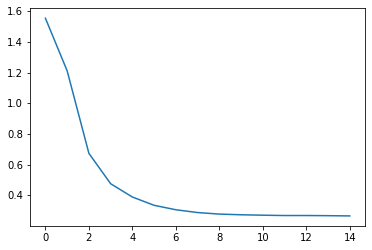

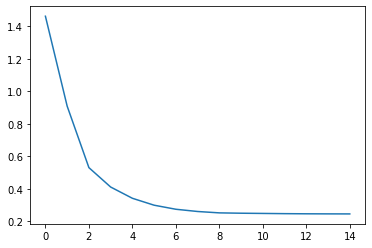

In [83]:
plt.figure()
plt.plot(range(15), train_loss)
plt.figure()
plt.plot(range(15), val_loss)

### Snippet to draw and test shape closeness

test loss: 0.24425128417856554
tensor(0.1525, device='cuda:0')
tensor(0.1251, device='cuda:0')


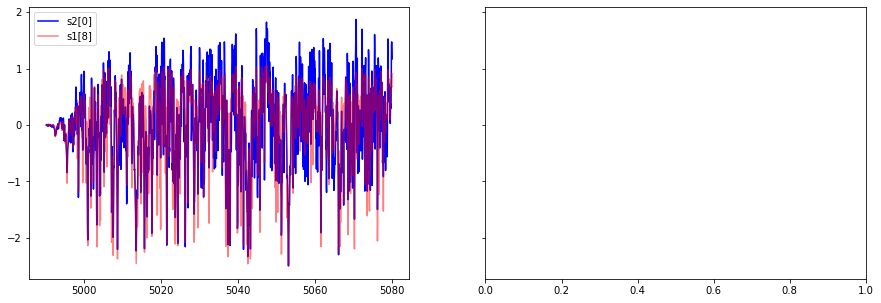

In [18]:
# spectraModel_test_big_drop = load_model_from_mode('spectra', True, 0.6, 1e-5).to(device)
# spectraModel = SpectraNet().to(device)
loss = nn.MSELoss(reduction = 'mean')
test_load.eval()
length = 90
skip = True
s1 = list(range(length))
s2 = list(range(length))
spec1 = list(range(length))
spec2 = list(range(length))
j = 0
k = j+8
running_loss = 0
with torch.no_grad():
    h = test_load.init_hidden()
    for i, (obs,specs,system,_,_) in enumerate(train_loader):
#         if i >= 10:
#             break
        specs = specs.to(device)
        #spec1[i], spec2[i] = normalize_tensor(specs[0,:]), normalize_tensor(specs[1,:])
        spec1[i], spec2[i] = specs[0,:], specs[1,:]
        s1[i],s2[i],h = test_load(split_vector_to_seqs(obs, seq_length=500, seq_amount=7500//500).to(device), h)
        #s1[i] = normalize_tensor(s1[i])
        #s2[i] = normalize_tensor(s2[i])
        running_loss += calc_loss(loss, s1[i],s2[i],spec1[i].view(1,-1),spec2[i].view(1,-1)).item()
#         if i < 10:
#             display_graphs(loss,s1[i][0],s2[i][0],spec1[i][:],spec2[i][:],std_dict['vector target'],system)

print(f'test loss: {running_loss / len(train_loader)}')
loss = nn.MSELoss(reduction = 'mean')
print(loss(s2[j][0], s1[k][0]))
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (15, 5))
ax1.plot(std_dict['vector target'], s2[j][0].cpu().detach().numpy(), color='blue', label = f's2[{j}]')
ax1.plot(std_dict['vector target'], s1[k][0].cpu().detach().numpy(), alpha = 0.5, color='red', label = f's1[{k}]')
ax1.legend()
print(loss(spec2[j], spec2[k]))
# print(loss(s2[0], s2[1]))
# print(loss(spec2[0], spec2[1]))

tensor([[4.0049e-07, 1.7829e-06, 4.1127e-06,  ..., 5.4825e-01, 3.8845e-01,
         3.8846e-01],
        [4.4857e-07, 1.9827e-06, 4.5738e-06,  ..., 8.8592e-01, 6.7519e-01,
         6.6624e-01]], dtype=torch.float64)
tensor(0.3200, dtype=torch.float64)


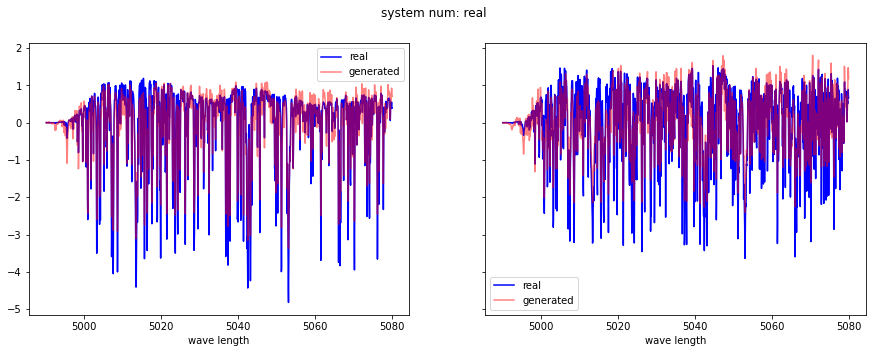

In [53]:
spectraModel_test_big_drop.eval()
real = get_real_loader(std_dict)
print(real[1])
with torch.no_grad():
    loss_function = nn.MSELoss(reduction = 'mean')
    h = spectraModel_test_big_drop.init_hidden()
    target = real[1].to(device)
    s1,s2,h = spectraModel_test_big_drop(split_vector_to_seqs(real[0], seq_length=500, seq_amount=7500//500).to(device), h)
    display_graphs(loss,s1[0],s2[0],target[0,:],target[1,:],std_dict['vector target'])
    #f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize = (15, 5))
    #ax1.plot(real[1][0,:].cpu().numpy(), color='blue')
    #ax2.plot(real[1][1,:].cpu().numpy(), color='blue')
    #ax3.plot(s2[0].cpu().numpy(), color='red')
    #ax4.plot(s1[0].cpu().numpy(), color='red')
    print(calc_loss(loss_function,s1.cpu(),s2.cpu(),target[0,:].view(1,-1).cpu(), target[1,:].view(1,-1).cpu()))

In [110]:
print(std_dict)

{'min source': 4991.797238496773, 'max source': 5088.175939566208, 'min target': 4990.122000000003, 'max target': 5089.85200000218, 'source len': 7500, 'target len': 1700, 'vector source': array([4991.7972385 , 4991.8100907 , 4991.82294291, ..., 5088.15023515,
       5088.16308736, 5088.17593957]), 'vector target': array([4990.122     , 4990.18069923, 4990.23939847, ..., 5089.73460153,
       5089.79330077, 5089.852     ])}


In [16]:
def train_spectra2(model, optimizer, train_loader, val_loader, epochs:int = 20, clip:int = 5):
    loss_function = nn.MSELoss(reduction = 'sum')
    model.train()
    seq_size, seq_amount, wave_amount = model.seq_size, model.seq_amount, model.wave_amount
    '''Training the First layers (the 1st spectra)'''
    train_loss_list1 = []
    val_loss_list1 = []
    train_loss_list2 = []
    val_loss_list2 = []
    train_amount = len(train_loader)
    val_amount = len(val_loader)
    for e in range(epochs):
        total_epoch_loss_train = 0
        total_epoch_loss_val = 0
        loss = 0
        hidden = model.init_hidden()
        model.train()
        for obs, specs, _, _, _ in train_loader:
            hidden = tuple([each.data for each in hidden]) 
            obs, specs = split_vector_to_seqs(obs, seq_size, seq_amount, wave_amount).to(device), specs.to(device)
            spectra1, hidden = model(obs, hidden, method=2)
            
            optimizer.zero_grad()
            loss = loss_function(spectra1.view(1,-1), specs[0,:].view(1,-1))
            loss.backward()
            total_epoch_loss_train += loss.item()
            
            nn.utils.clip_grad_norm_(model.parameters(), clip) 
            optimizer.step()
            
        val_hidden = model.init_hidden()
        model.eval()
        with torch.no_grad():
            for obs, specs, _, _, _ in val_loader:
                hidden = tuple([each.data for each in hidden]) 
                obs, specs = split_vector_to_seqs(obs, seq_size, seq_amount, wave_amount).to(device), specs.to(device)
                spectra1, hidden = model(obs, hidden, method=2)

                loss = loss_function(spectra1.view(1,-1), specs[0,:].view(1,-1))
                total_epoch_loss_train += loss.item()
        
        train_loss_list1.append(total_epoch_loss_train/train_amount)
        val_loss_list1.append(total_epoch_loss_val/val_amount) 
        print("Epoch: {}/{}...".format(e+1, epochs),
            "Train Loss: {:.4f}...".format(train_loss_list1[e]),
            "Validation Loss: {:.4f}...".format(val_loss_list1[e]))
    print()
    print('End of Spectra1 Training')
    print()
    
    '''Training the Last layer (the 2nd spectra)'''
    
    model.eval() #eval because we wan't the dropout to not drop because we don't backprop on layers connected to it
    req_grad = False
    for param in model.parameters():
        if param.size() == torch.Size([1700, 1700]): # the params from here are the last layer and its bias
            req_grad = True
        param.requires_grad = req_grad
        
    for e in range(epochs//2):
        total_epoch_loss_train = 0
        total_epoch_loss_val = 0
        loss = 0
        hidden = model.init_hidden()
        for obs, specs, _, _, _ in train_loader:
            hidden = tuple([each.data for each in hidden]) 
            obs, specs = split_vector_to_seqs(obs, seq_size, seq_amount, wave_amount).to(device), specs.to(device)
            spectra1, hidden = model(obs, hidden, method=2)
            spectra2 = model.forward_method_2(spectra1.data)
#             print(spectra2.shape)
            optimizer.zero_grad()
            loss = loss_function(spectra2.view(1,-1), specs[1,:].view(1,-1))
            loss.backward()
            total_epoch_loss_train += loss.item()
            
            nn.utils.clip_grad_norm_(model.parameters(), clip) 
            optimizer.step()
            
        val_hidden = model.init_hidden()
        model.eval()
        with torch.no_grad():
            for obs, specs, _, _, _ in val_loader:
                hidden = tuple([each.data for each in hidden]) 
                obs, specs = split_vector_to_seqs(obs, seq_size, seq_amount, wave_amount).to(device), specs.to(device)
                spectra1, hidden = model(obs, hidden, method=2)
                spectra2 = model.forward_method_2(spectra1.data)

                loss = loss_function(spectra2.view(1,-1), specs[1,:].view(1,-1))
                total_epoch_loss_train += loss.item()
        
        train_loss_list2.append(total_epoch_loss_train/train_amount)
        val_loss_list2.append(total_epoch_loss_val/val_amount) 
        print("Epoch: {}/{}...".format(e+1, epochs),
            "Train Loss: {:.4f}...".format(train_loss_list2[e]),
            "Validation Loss: {:.4f}...".format(val_loss_list2[e]))
    print()
    print('End of Spectra2 Training')
    print()
    return model, train_loss_list1, val_loss_list1

In [17]:
test = SpectraNet()
req_grad = False
opt = torch.optim.Adam(test.parameters())
for param in test.parameters():
    if param.size() == torch.Size([1995, 1995]): # the params from here are the last layer and its bias
        req_grad = True
    param.requires_grad = req_grad
print(opt)
# for param in opt.params:
#     print(f'param: required grad: {param.requires_grad}, size: {param.size()}')

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


# The Speed - Dopler Network
This network is meant to calculate the speed of the stars at the sampling point according to the spectra measured in said time points.

we can either give the net a vector of all the wave samples at a specific time and ask for a single result - single speed of the star at the time of measurments *(one-directional RNN)*. OR: give it the resulted spectra from the spectra network and output a full vector of speeds *(bidirectional RNN)*

In [39]:
class DopplerNet(nn.Module):
    def __init__(self, method=2.5, with_drop=True, hidden_size=hidden_size_doppler,
                 n_layers=num_layers_doppler, drop=drop_doppler, batch_size=batch_size,
                 wave_amount_sample=truncated_length, wave_amount_predict=new_wave_output, 
                 seq_size=doppler_sequence_length25, obs_amount=observation_amount,
                 combine_wave_input=concat_value_output):
        '''
        wave_amount: the size of the amount of inputs in the RNN
        
        we need to create 3 different dopppler nets INSTANCES (according to the 3 different methods - we can make the 
        forward method change according to the train method)
        Also add the correct variables for the init method 
        '''
        super(DopplerNet, self).__init__()
        self.with_drop = with_drop
        self.method = method
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.drop = drop
        self.batch_size = batch_size
        self.seq_size = seq_size
        self.wave_amount_sample = wave_amount_sample #7500
        self.wave_amount_predict = wave_amount_predict #1700
        self.combine_wave_input = combine_wave_input #9650
        self.obs_amount = obs_amount # the amount of observation - velocities.

        if self.with_drop: 
            if self.method == 1 or self.method == 2:
                #Training method 1&2
                # We get a spectra of a single star and we need to return a vector of velocities.
                self.rnn_doppler = nn.LSTM(seq_size, hidden_size, n_layers, 
                                           dropout=drop, batch_first=True, bidirectional=True)
                self.dropout = nn.Dropout(drop)
                self.fc = nn.Sequential(nn.Linear(self.new_wave_amount, 512),#we get the spectra and return a vector of 20 velocities
                                        nn.ReLU(),
                                        self.dropout,
                                        nn.Linear(512, self.obs_amount))
                if self.wave_amount_predict % self.seq_size == 0:
                    self.seq_amount = self.wave_amount_predict // self.seq_size
                else:
                    raise ValueError("seq_size deosn't devide the input length")
            elif self.method == 2.5:
                #Training method 2.5
                self.rnn_doppler = nn.LSTM(seq_size, hidden_size, n_layers, 
                                           dropout=drop, batch_first=True, bidirectional=False)
                #We take the output of the last cell and use it
                self.dropout = nn.Dropout(drop)
                self.fc = nn.Sequential(nn.Linear(self.seq_size, 64),#we get the spectra and return a vector of 20 velocities
                                        nn.ReLU(),
                                        self.dropout,
                                        nn.Linear(64, 1))
                if self.combine_wave_input % self.seq_size == 0:
                    self.seq_amount = self.combine_wave_input // self.seq_size
                else:
                    raise ValueError("seq_size deosn't devide the input length")
                
        else:
            if self.method == 1 or self.method == 2:
                #Training method 1&2
                # We get a spectra of a single star and we need to return a vector of velocities.
                self.rnn_doppler = nn.LSTM(seq_size, hidden_size, n_layers, 
                                           batch_first=True, bidirectional=True)
                self.fc = nn.Sequential(nn.Linear(self.new_wave_amount, 512),#we get the spectra and return a vector of 20 velocities
                                        nn.ReLU(),
                                        nn.Linear(512, self.obs_amount))
                if self.wave_amount_predict % self.seq_size == 0:
                    self.seq_amount = self.wave_amount_predict // self.seq_size
                else:
                    raise ValueError("seq_size deosn't devide the input length")
            elif self.method == 2.5:
                #Training method 2.5
                self.rnn_doppler = nn.LSTM(seq_size, hidden_size, n_layers, 
                                           batch_first=True, bidirectional=False)
                #We take the output of the last cell and use it
                self.fc = nn.Sequential(nn.Linear(self.seq_size, 64),#we get the spectra and return a vector of 20 velocities
                                        nn.ReLU(),
                                        nn.Linear(64, 1)) 
                if self.combine_wave_input % self.seq_size == 0:
                    self.seq_amount = self.combine_wave_input // self.seq_size
                else:
                    raise ValueError("seq_size deosn't devide the input length")
            
      
    def forward(self, waves, hidden):
        '''
        WE SPLIT THE INPUTS TO SEQUENCES BEFORE THE FORWARD FUNCTION
        
        waves: the the star predicted spectra tensor (batch_size X seq_amount X seq_length) - we "duplicate"
        it so its has a batch size of 20 and not 1 in methhod 2.5, in 1&2 the batch size is 2 (only one system per forward)
        hidden: the hidden state with its regular size
        
        NOTICE: if we use method 2.5 waves is a concatenation of the observations and the predicted spectra
        (splitted to seqs and with a batch_size = observation_amount) 
        '''
        velocity = None #Currently equal to none
        
        if self.with_drop:
            velocity = self.dropout(waves)
        velocity, hidden = self.rnn_doppler(velocity, hidden)
        if self.with_drop:
            velocity = self.dropout(velocity)
            
        if self.method == 2.5:
            velocity = velocity[:,-1,:] #taking the last output sequence = most affected by the predicted spectra of the star
            velocity = velocity.view(self.batch_size, self.seq_size)
        elif self.method == 1 or self.method == 2:
            velocity = combine_seqs_to_vector(velocity, velocity.shape[1]*velocity.shape[2]) # 20 X seq_amount*seq_length
        velocity = self.fc(velocity)
        return velocity, hidden
    
              
    def init_hidden(self):
        '''In GRU we only carry on a hidden state and not a tuple of (hidden, c)
    
        Also not sure about the size of the hidden because our data is actually 2D and not a regular sequence - 
        probably will just feed all 20 and mean over the results or something similar
        '''
        weight = next(self.parameters()).data
        # if self.mode == 'LSTM':
        if device == 'cuda':
            hidden = (weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_().cuda(),
                weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_(),
                    weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_())
        # else:
        #   if device == 'cuda':
        #       hidden = weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_().cuda()
        #   else:
        #       hidden = weight.new(self.n_layers, self.batch_size, self.hidden_size).zero_()
        return hidden

# The Training - DopplerNet
we have 2.5 training methods: 

## 1. end-to-end
this style of training, train both the spectra and the speed net at the same time with backprop going on both for each input and output - because we use a lot of data and big RNN it might cause some gradient vanishings.

## 2. Auto-Encoder style training
we first train the spectra net and achieve a good enough loss value, and then we train the doppler net with the spectra results.

### 2.5. Auto-Encoder + time sampled spectra
we first train the spectra net and achieve a good enough loss value, and then we train the doppler net with the data of both the spectra sampling of the whole system at a time point + the spectra we got from our net (either concatanating or doing some other operation).

In [76]:
def train_doppler25(spectra_net, doppler_net, optimizer, scheduler, train_loader, val_loader, epochs:int = 20 ,clip:int = 2):
    loss_function = nn.MSELoss(reduction = 'mean')
    doppler_net.train()
    input_length, seq_size, seq_amount = doppler_net.combine_wave_input, doppler_net.seq_size, doppler_net.seq_amount
    spectra_net.eval()
    for param in spectra_net.parameters():
        param.requires_grad = False
    
    train_loss_list = []
    val_loss_list = []
    for e in range(epochs):
        total_epoch_loss_train = 0
        total_epoch_loss_val = 0
        loss = 0
        spectra_hidden = spectra_net.init_hidden()
        doppler_hidden = doppler_net.init_hidden()
        
        doppler_net.train()
        for obs, specs, _, times, velocities in train_loader:
            spectra_hidden = tuple([each.data for each in spectra_hidden])
            doppler_hidden = tuple([each.data for each in doppler_hidden])

            doppler_input = torch.cat((obs.repeat(2,1),
                                       torch.cat(
                                           (specs[0,:].repeat(20,1), specs[1,:].repeat(20,1)),0)),1)
            
            doppler_input = split_vector_to_seqs(doppler_input, seq_size, seq_amount,
                                                 input_length).to(device)

            optimizer.zero_grad()
            output, doppler_hidden = doppler_net(doppler_input, doppler_hidden)
            output = output.view(2,20)
            velocities = velocities.to(device)
            loss = calc_loss(loss_function, output[0,:],output[1,:],velocities[0,:], velocities[1,:])
            #loss = loss_function(output, velocities.to(device))
            loss.backward()
            total_epoch_loss_train += loss.item()
            
#             nn.utils.clip_grad_norm_(doppler_net.parameters(), clip) 
            optimizer.step()
            
        spectra_val_hidden = spectra_net.init_hidden()
        doppler_val_hidden = doppler_net.init_hidden()
        
        doppler_net.eval()
#         print("VALIDATION STARTS")
        with torch.no_grad():
            for obs, specs, _, times, velocities in val_loader:
                spectra_val_hidden = tuple([each.data for each in spectra_val_hidden]) 
                doppler_val_hidden = tuple([each.data for each in doppler_val_hidden]) 
                doppler_input = torch.cat((obs.repeat(2,1),
                                      torch.cat((specs[0,:].repeat(20,1), specs[1,:].repeat(20,1)), 0)), 1)
#             print(f'spectra1 size: {spectra1.size()}, specs: {specs[:, 0].size()}')
                output, doppler_val_hidden = doppler_net(split_vector_to_seqs(doppler_input, seq_size, seq_amount,
                                                                          input_length).to(device), doppler_val_hidden)
                output = output.view(2,20)
                velocities = velocities.to(device)
                loss = calc_loss(loss_function, output[0,:],output[1,:],velocities[0,:], velocities[1,:])
                #loss = loss_function(output, velocities.to(device))
                total_epoch_loss_val += loss.item()
        
        train_loss_list.append(total_epoch_loss_train/len(train_loader))
        val_loss_list.append(total_epoch_loss_val/len(val_loader)) 
        print("Epoch: {}/{}...".format(e+1, epochs),
            "Train Loss: {:.4f}...".format(train_loss_list[e]),
            "Validation Loss: {:.4f}...".format(val_loss_list[e]),
             "LR: {}".format(scheduler.get_last_lr()))
        scheduler.step()
    return doppler_net, train_loss_list, val_loss_list

In [78]:
dop_new = DopplerNet(batch_size = 40).to(device) #40 because there are 20 observation but 2 systems to predict so: 20*2
opt = optim.Adam(dop_new.parameters(), weight_decay=1e-2, lr=0.00011)
epochs_amount = 15
lambda_lr = lambda epoch: 0.5 if epoch+1 > (epochs_amount//3)*2 and (epoch+1)%2 == 0 else 1
#lambda_lr = lambda epoch: 1 if epoch > epochs_amount//2 else 1
schedu = optim.lr_scheduler.MultiplicativeLR(opt, lr_lambda = lambda_lr)
dop_new, tr, vl = train_doppler25(spectraModel, dop_new, opt, schedu, train_loader, val_loader, epochs=epochs_amount)

Epoch: 1/15... Train Loss: 114.9945... Validation Loss: 123.6946... LR: [0.00011]
Epoch: 2/15... Train Loss: 114.7566... Validation Loss: 123.3768... LR: [0.00011]
Epoch: 3/15... Train Loss: 112.8810... Validation Loss: 117.3321... LR: [0.00011]
Epoch: 4/15... Train Loss: 100.8749... Validation Loss: 105.0532... LR: [0.00011]
Epoch: 5/15... Train Loss: 82.2865... Validation Loss: 94.0992... LR: [0.00011]
Epoch: 6/15... Train Loss: 65.8693... Validation Loss: 59.7066... LR: [0.00011]
Epoch: 7/15... Train Loss: 60.2774... Validation Loss: 45.0464... LR: [0.00011]
Epoch: 8/15... Train Loss: 55.5094... Validation Loss: 44.0933... LR: [0.00011]
Epoch: 9/15... Train Loss: 48.5268... Validation Loss: 38.4334... LR: [0.00011]
Epoch: 10/15... Train Loss: 47.8430... Validation Loss: 38.9891... LR: [0.00011]
Epoch: 11/15... Train Loss: 41.6489... Validation Loss: 34.4462... LR: [0.00011]
Epoch: 12/15... Train Loss: 41.1927... Validation Loss: 38.4405... LR: [5.5e-05]
Epoch: 13/15... Train Loss: 3

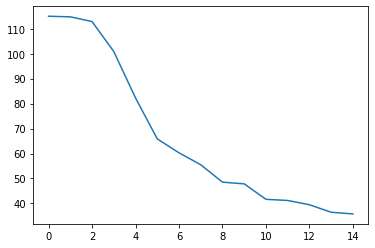

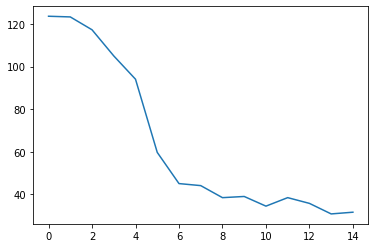

In [90]:
plt.figure()
plt.plot(tr)
plt.figure()
plt.plot(vl)

In [20]:
it = iter(val_loader)
tup = next(it)
tup = next(it)
tup = next(it)
tup = next(it)
tup = next(it)
# tup = next(it)
repeat_time = 7
print(len(tup))
dop_new.eval()
with torch.no_grad():
#     spec1, spec2, _ = spectraModel(split_vector_to_seqs(tup[0]).to(device), spectraModel.init_hidden())
#     inp = torch.cat((tup[0].repeat(2,1),torch.cat((spec1.cpu().repeat(20,1), spec2.cpu().repeat(20,1)), 0)), 1)
    inp = torch.cat((tup[0].repeat(2,1),torch.cat((tup[1][0,:].repeat(20,1), tup[1][1,:].repeat(20,1)), 0)), 1)
    predicted, _ = dop_new(split_vector_to_seqs(inp, dop_new.seq_size, dop_new.seq_amount,
                                                    dop_new.combine_wave_input).to(device), dop_new.init_hidden())
    predicted = predicted.view(2,20)
    print(predicted.shape)
#     plt.figure(figsize = [6,4])
#     plt.scatter(tup[3]%8, predicted[0,:].cpu().numpy(), color='red')
#     plt.scatter(tup[3]%8, tup[4][0,:].numpy(), color='blue')
#     plt.figure(figsize = [6,4])
#     plt.scatter(tup[3], predicted[1,:].cpu().numpy(), color='red')
#     plt.scatter(tup[3], tup[4][1,:].numpy(), color='blue')
    plt.figure(figsize = [10,5])
#     plt.scatter(tup[3], predicted[0,:].cpu().numpy(), color='red')
#     plt.scatter(tup[3], predicted[1,:].cpu().numpy(), color='blue')
    plt.scatter(tup[3]%repeat_time, tup[4][0,:].numpy(), color='blue')
    plt.scatter(tup[3]%repeat_time, predicted[0,:].cpu().numpy(), color='orange')
    plt.figure(figsize = [10,5])
    plt.scatter(tup[3]%repeat_time, tup[4][1,:].numpy(), color='blue')
    plt.scatter(tup[3]%repeat_time, predicted[1,:].cpu().numpy(), color='orange')


5


NameError: name 'dop_new' is not defined

In [40]:
dop_new = load_model_from_mode('doppler', True, drop=0.5, lr=0.00011)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

total loss: 40.16696548461914


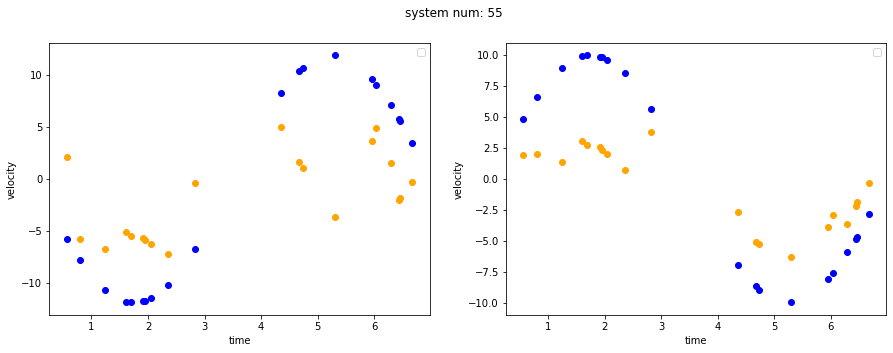

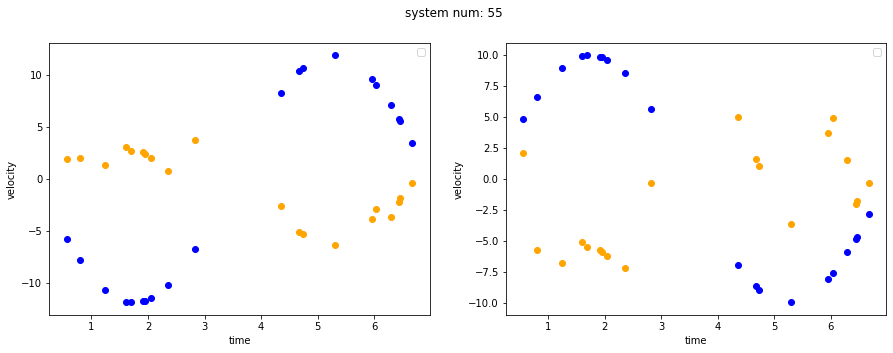

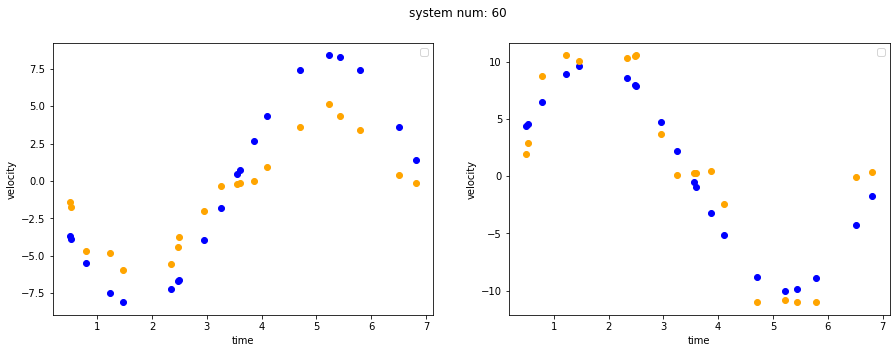

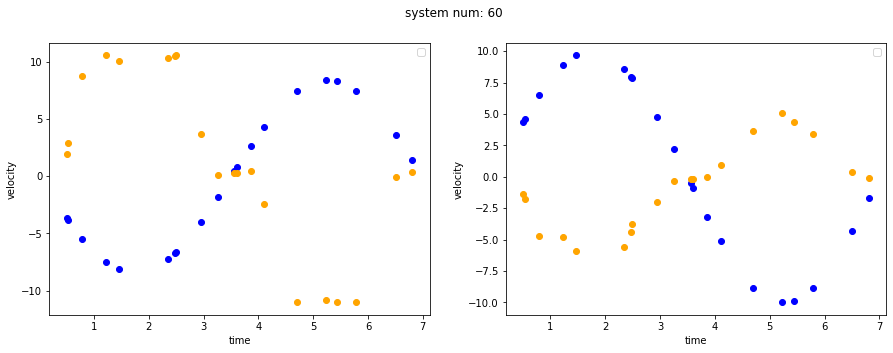

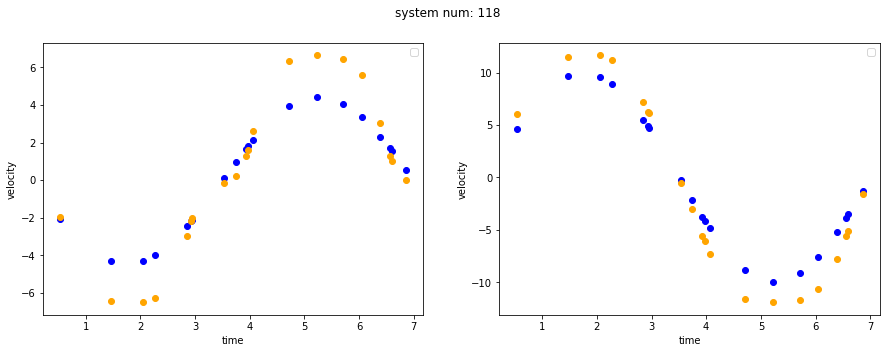

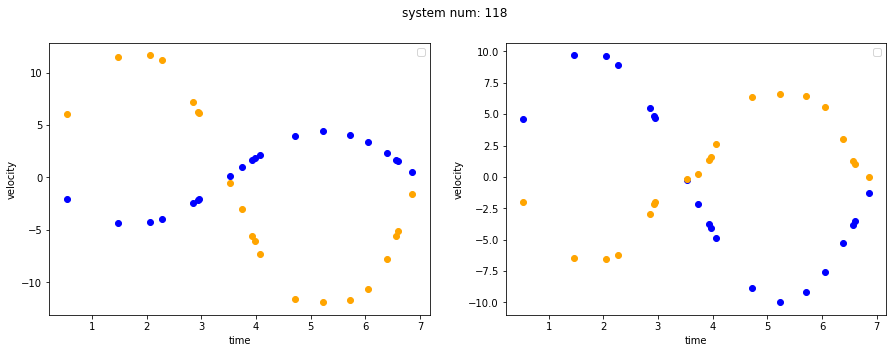

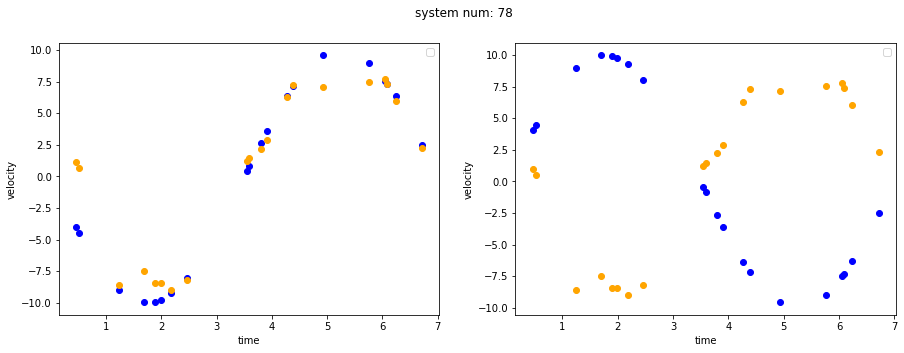

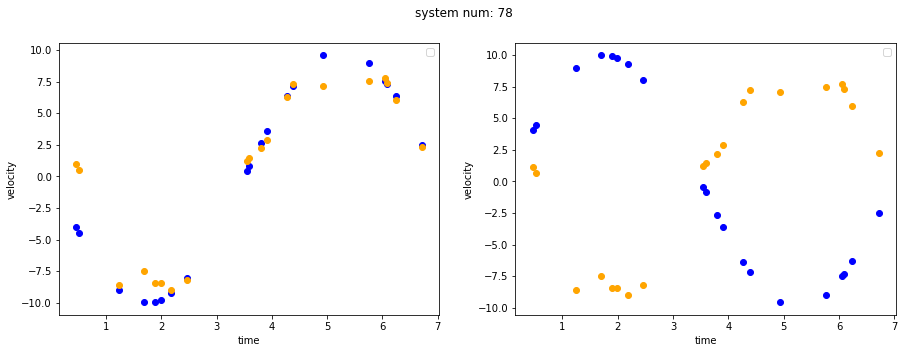

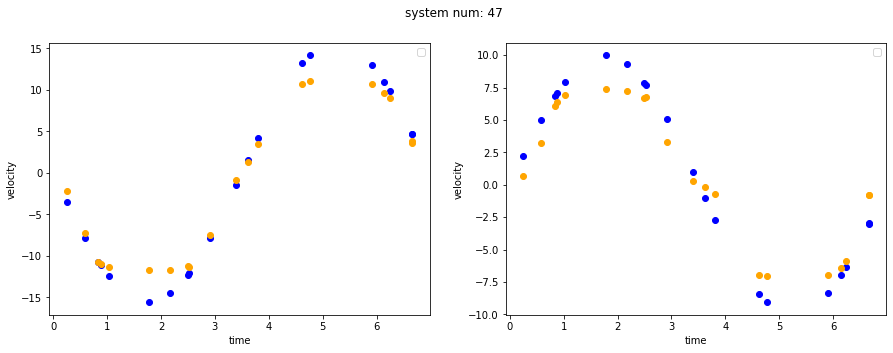

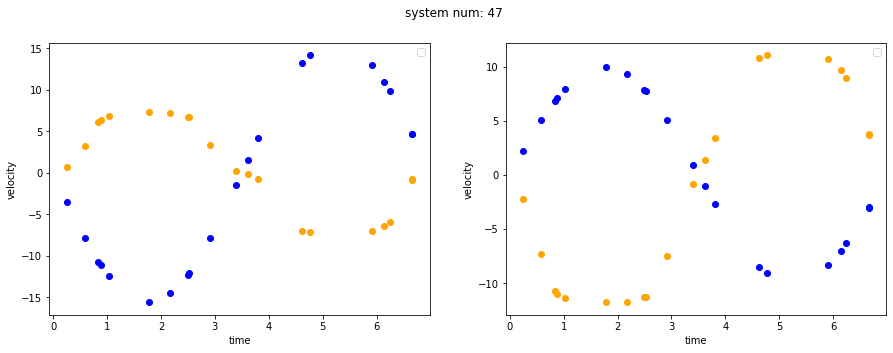

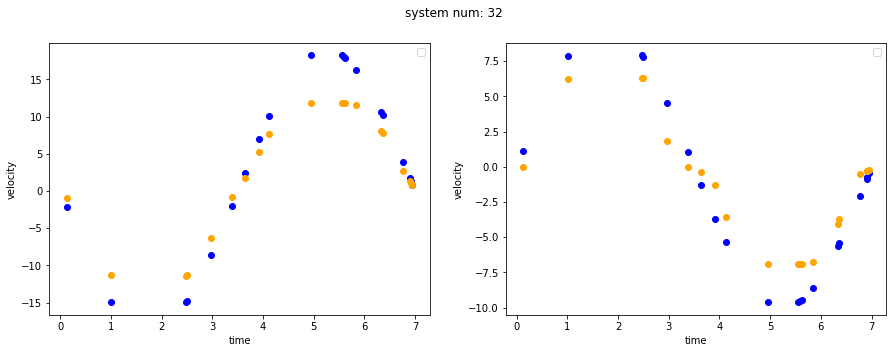

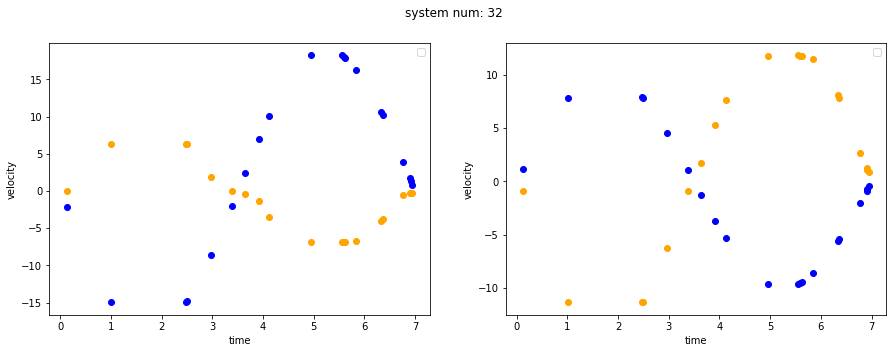

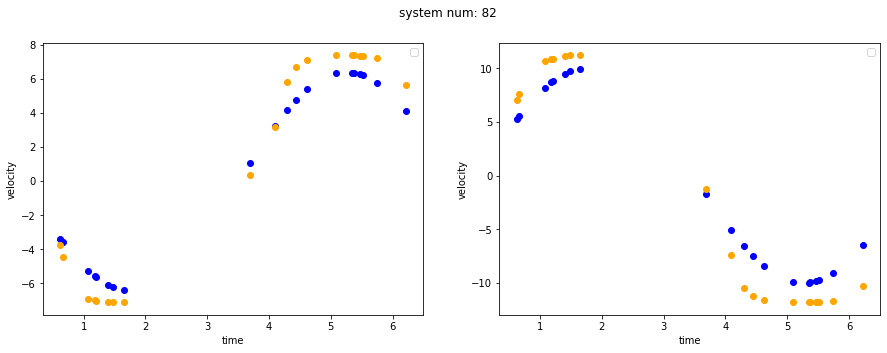

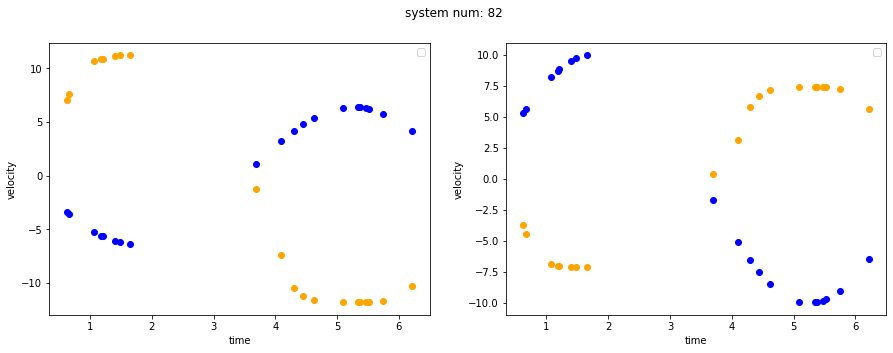

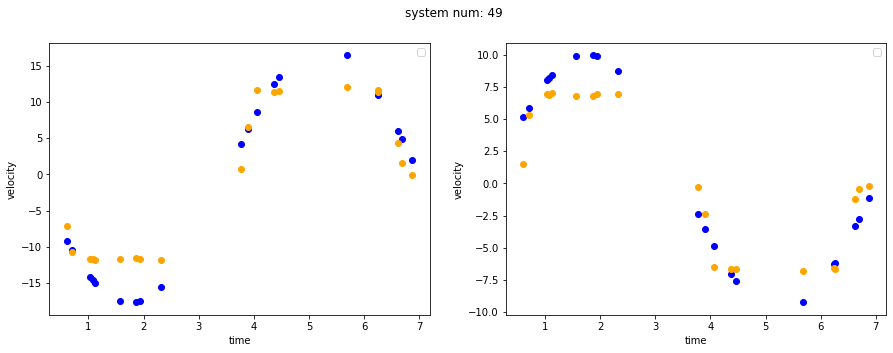

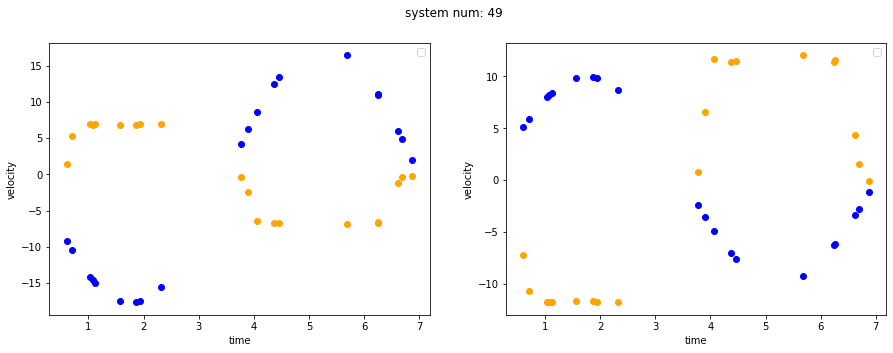

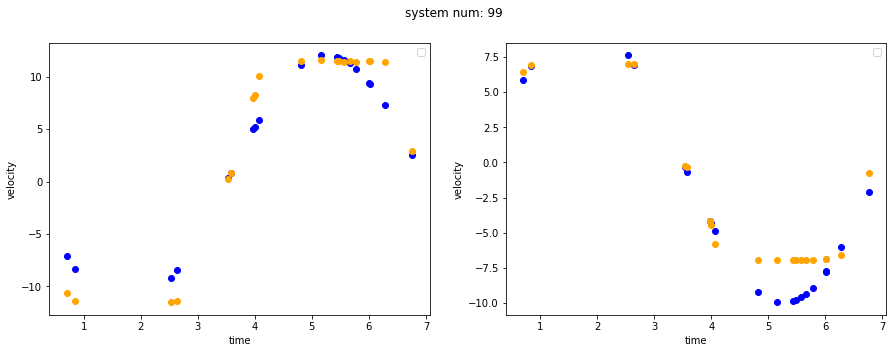

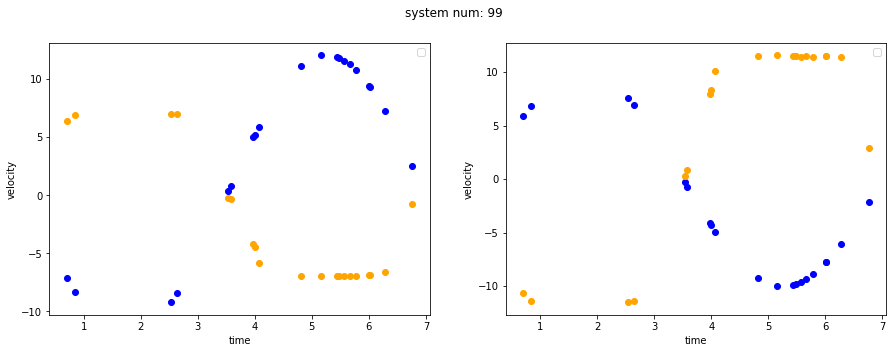

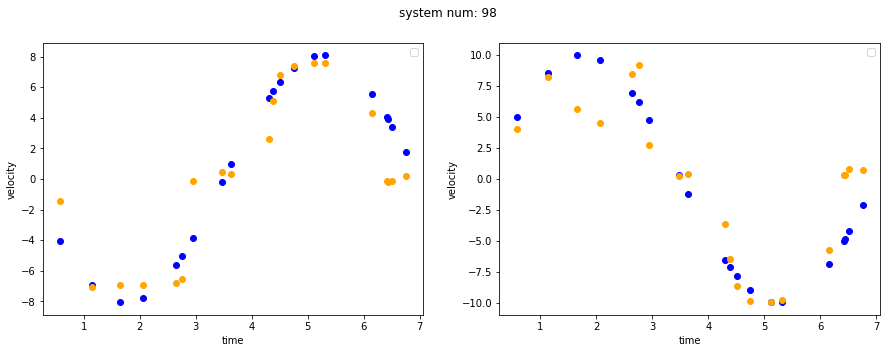

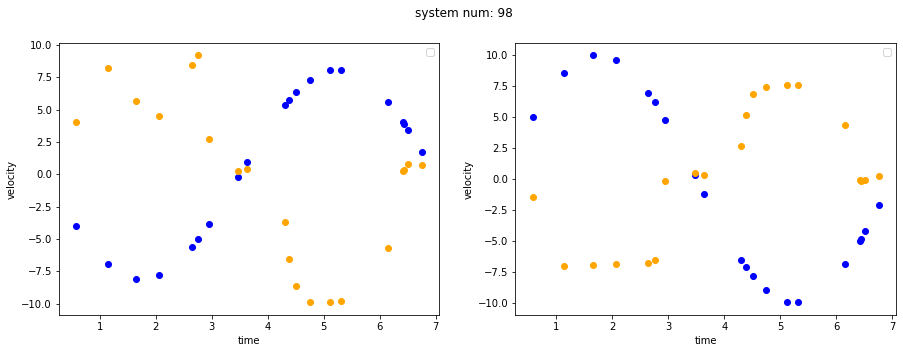

In [53]:
dop_new = dop_new.to(device)
loss_function = nn.MSELoss(reduction = 'mean')
repeat_time = 7
dop_new.eval()
with torch.no_grad():
    running_loss = 0
    for i, (obs, specs, system_id, times, velocities) in enumerate(train_loader):
        doppler_hidden = dop_new.init_hidden()

        doppler_input = torch.cat((obs.repeat(2,1),
                                   torch.cat(
                                       (specs[0,:].repeat(20,1), specs[1,:].repeat(20,1)),0)),1)

        doppler_input = split_vector_to_seqs(doppler_input, dop_new.seq_size, dop_new.seq_amount,
                                             dop_new.combine_wave_input).to(device)
        output, doppler_hidden = dop_new(doppler_input, doppler_hidden)
        output = output.view(2,20)
        velocities = velocities.to(device)
        loss = calc_loss(loss_function, output[0,:],output[1,:],velocities[0,:], velocities[1,:])
        running_loss += loss
        if i < 10:
            f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize = (15, 5))
            ax1.scatter(times%repeat_time, velocities[0,:].cpu().numpy(), label='real', color='blue')
            ax1.scatter(times%repeat_time, output[0,:].cpu().numpy(), label='predicted', color='orange')
            ax2.scatter(times%repeat_time, velocities[1,:].cpu().numpy(), label='real', color='blue')
            ax2.scatter(times%repeat_time, output[1,:].cpu().numpy(), label='predicted', color='orange')
            f.suptitle(f'system num: {system_id}')
            ax1.set_xlabel('time')
            ax2.set_xlabel('time')
            ax1.set_ylabel('velocity')
            ax2.set_ylabel('velocity')
            ax1.legend()
            ax2.legend()

            f2, (ax3, ax4) = plt.subplots(1, 2, sharey=False, figsize = (15, 5))
            ax3.scatter(times%repeat_time, velocities[0,:].cpu().numpy(), label='real', color='blue')
            ax3.scatter(times%repeat_time, output[1,:].cpu().numpy(), label='predicted', color='orange')
            ax4.scatter(times%repeat_time, velocities[1,:].cpu().numpy(), label='real', color='blue')
            ax4.scatter(times%repeat_time, output[0,:].cpu().numpy(), label='predicted', color='orange')
            f2.suptitle(f'system num: {system_id}')
            ax3.set_xlabel('time')
            ax4.set_xlabel('time')
            ax3.set_ylabel('velocity')
            ax4.set_ylabel('velocity')
            ax3.legend()
            ax4.legend()
    print(f'total loss: {running_loss/len(train_loader)}')

In [94]:
save_model_with_checkpoint(dop_new, 0.00011, 'doppler')

# Test Functions and Code Slices

In [ ]:
def train_doppler25(spectra_net, doppler_net, optimizer, train_loader, val_loader, epochs:int = 20, clip:int = 5):
    loss_function = nn.MSELoss(reduction = 'sum')
    doppler_net.train()
    input_length, seq_size, seq_amount = doppler_net.combine_wave_input, doppler_net.seq_size, doppler_net.seq_amount
    spectra_net.eval()
    for param in spectra_net.parameters():
        param.requires_grad = False
    
    train_loss_list = []
    val_loss_list = []
    for e in range(epochs):
        total_epoch_loss_train = 0
        total_epoch_loss_val = 0
        loss = 0
        spectra_hidden = spectra_net.init_hidden()
        doppler_hidden = doppler_net.init_hidden()
        
        doppler_net.train()
        for obs, specs, _, times, velocities in train_loader:
            spectra_hidden = tuple([each.data for each in spectra_hidden])
            doppler_hidden = tuple([each.data for each in doppler_hidden])
            '''NEED TO UPDATE THE SIZES - MAKE THEM A PARAMETER TO THE TRAIN FUNCTION'''
#             obs, specs = split_vector_to_seqs(obs).to(device), specs.to(device)
#             spectra1, spectra2, hidden = model(obs, hidden, method=1)
            doppler_input = torch.cat(obs.repeat(2,1),
                                      torch.cat(specs[0,:].repeat(20,1), specs[1,:].repeat(20,1), dim=0), dim=1).to(device)
#             print(f'spectra1 size: {spectra1.size()}, specs: {specs[:, 0].size()}')
            optimizer.zero_grad()
            output, doppler_hidden = doppler_net(doppler_input, doppler_hidden)
            output = output.view(2,20)
            loss = loss_function(output, velocities)
            loss.backward()
            total_epoch_loss_train += loss.item()
            
            nn.utils.clip_grad_norm_(model.parameters(), clip) 
            optimizer.step()
            
        spectra_val_hidden = spectra_net.init_hidden()
        doppler_val_hidden = doppler_net.init_hidden()
        
        doppler_net.eval()
        print("VALIDATION STARTS")
        with torch.no_grad():
            for obs, specs, _, times, velocities in val_loader:
                spectra_val_hidden = tuple([each.data for each in spectra_val_hidden]) 
                doppler_val_hidden = tuple([each.data for each in doppler_val_hidden]) 
                obs, specs = split_vector_to_seqs(obs).to(device), specs.to(device)
                spectra1, spectra2, hidden = model(obs, hidden, method=1)

                loss1 = loss_function(spectra1.view(1,-1), specs[:,0].view(1,-1))
                loss2 = loss_function(spectra2.view(1,-1), specs[:,1].view(1,-1))
                total_epoch_loss_val += loss1.item() + loss2.item()
        
        train_loss_list.append(total_epoch_loss_train)
        val_loss_list.append(total_epoch_loss_val) 
        print("Epoch: {}/{}...".format(e+1, epochs),
            "Train Loss: {:.4f}...".format(train_loss_list[e]),
            "Validation Loss: {:.4f}...".format(val_loss_list[e]))
    return model, train_loss_list, val_loss_list

In [ ]:
# test = next(iter(dataLoader))
# print
# for item in test:
#     print(item.size())
it = 0

# print(len(dataLoader))
for a,b,c,d,e in train_loader:
    if b.size()[0] < 1995:
    #     hidden = spectraModel.init_hidden()
#         print(a.size(), a.type()) # The system spectra sampled
        print(f'system number: {c}') # The index of the system
        print(b.size(), b.type()) # The spectra of the two stars in the system
#         print(f'size: {d.size()}, type: {d.type()}') # d is the time we sample the system
#         print(f'size: {e.size()}, type: {e.type()}') # e is the time we speed of the system at the coreesponding time
#     if it >= 4: 
#         break
#     it += 1
print('all good size')

In [ ]:
n = [1995, 7651, 7651+1995, 3764]
length = [50, 100]
for l in length:
    for ns in n:
        res = find_closest_round(ns, l)
        print(f'chose: {res}')

In [ ]:
b = torch.randn(4,52)
print(b.size())
b = b[:, :50]
print(b.size())
seq_temp = 5
print(b.dim)
b = b.view(-1, b.size()[-1]//seq_temp, seq_temp)
print(b.size())
b.view

In [ ]:
'''NOT SURE IF THIS FUNCTIONS WILL WORK WELL IN THE COLLAB (BECAUSE IT DOESN'T SAVE THE FILES WHEN YOU DISCONNECT
FROM THE COLLAB SERVER) WE NEED TO SAVE THE FILES ON THE DRIVE HERE'''
def sample_file(file_path):
    data = pd.read_csv(file_path)
    data = data.iloc[::5]
    return data

def create_target_files(dir_path, target_dir):
    for filename in os.listdir(dir_path):
        if filename[3] == '0' or filename[3] == 'O' or filename[2] == '0' or filename[2] == 'O': 
            full_path = os.path.join(dir_path, filename)
            if "vrad" in filename:
                sampled = pd.read_csv(full_path)
            else:
                sampled = sample_file(full_path)
            path_to_write = os.path.join(target_dir,filename)
            sampled.to_csv(path_to_write, index = False)


In [ ]:
dataloader = getLoader()
test = next(iter(dataloader))
for item in test:
    if type(item) is int:
        print(item)
    else:
        if item.size()[-1] >= 50:
            item = split_vector_to_seqs(item)
            item = combine_seqs_to_vector(item)
        print(item.shape)

In [ ]:
a = torch.randn(5,5)
z = torch.zeros(5,2)
print(torch.cat((a, z), 1))
print(a.size(), a)
print(a[-5:])

tr = torch.zeros(20, 153, 50)
tr = tr.view(-1, 153*50)
print(tr.size())

In [ ]:
check = torch.ones(3)
print(f'check: {3 in check}')

In [ ]:
train, test, val = getLoader()

In [ ]:
train, test, val = getLoader()

for a,b,c,d,e in train:
#     print(a.size(), b.size(), d.size(), e.size())
    break
    if True in torch.isnan(a):
        print(f'there is a nan, in system: {c} in vector obs: {a}')
    if True in torch.isnan(b):
        print(f'there is a nan, in system: {c} in vector ground truth {b}')
        break
    if True in torch.isnan(d):
        print(f'there is a nan, in system: {c} in vector doppler {d}')
        break
    if True in torch.isnan(e):
        print(f'there is a nan, in system: {c} in vector real doppler {e}')
        break
print('no nans is train')
for a,b,c,d,e in test:
#     print(a.size(), b.size(), d.size(), e.size())
    break
    if True in torch.isnan(a):
        print(f'there is a nan, in system: {c} in vector obs: {a}')
    if True in torch.isnan(b):
        print(f'there is a nan, in system: {c} in vector ground truth {b}')
        break
    if True in torch.isnan(d):
        print(f'there is a nan, in system: {c} in vector doppler {d}')
        break
    if True in torch.isnan(e):
        print(f'there is a nan, in system: {c} in vector real doppler {e}')
        break
print('no nans is test')
for a,b,c,d,e in val:
#     print(a.size(), b.size(), d.size(), e.size())
    break
    if True in torch.isnan(a):
        print(f'there is a nan, in system: {c} in vector obs: {a}')
    if True in torch.isnan(b):
        print(f'there is a nan, in system: {c} in vector ground truth {b}')
        break
    if True in torch.isnan(d):
        print(f'there is a nan, in system: {c} in vector doppler {d}')
        break
    if True in torch.isnan(e):
        print(f'there is a nan, in system: {c} in vector real doppler {e}')
        break
print('no nans is val')

In [ ]:
def find_factors(num: int):
    divs = []
    for div in range(5,num//2, 5):
        if num%div == 0:
            divs.append(div)
    print(divs)

In [ ]:
find_factors(9200)

In [ ]:
a = torch.randn(2,3,4)+2*torch.ones(2,3,4)
print(a)
# print(a.view(3,2,4))
a = a + torch.ones_like(a)
# print(a)
print(a.view(2,3,4))

In [59]:
a = torch.randint(40,(20,2))
b1, b2 = torch.randint(40,(1,2)), torch.randint(40,(1,2))
# b.fill_(a)
print(a.shape)
print(b1.shape, b2.shape)
doppler_input = torch.cat((a.repeat(2,1), torch.cat((b1.repeat(20,1), b2.repeat(20,1)), 0)), 1)
print(type(doppler_input), len(doppler_input), doppler_input.shape)

torch.Size([20, 2])
torch.Size([1, 2]) torch.Size([1, 2])
<class 'torch.Tensor'> 40 torch.Size([40, 4])


In [ ]:
            #f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize = (15, 5))
            #ax1.plot(spec2[i][:].cpu().numpy(), color='blue')
            #ax2.plot(spec1[i][:].cpu().numpy(), color='blue')
            #ax3.plot(s2[i][0].cpu().numpy(), color='red')
            #ax4.plot(s1[i][0].cpu().numpy(), color='red')
            #fig = plt.figure()
            #fig.suptitle(t = f'system: {system}')
            #plt.plot(spec2[i][:].cpu().numpy(), color='red')
            #plt.plot(s2[i][0].cpu().numpy(), color='blue', alpha = 0.5)
            #fig = plt.figure()
            #fig.suptitle(t = f'system: {system}')
            #plt.plot(spec2[i][:].cpu().numpy(), color='red')
            #plt.plot(s2[i][0].cpu().numpy(), color='blue', alpha = 0.5)

#             fig = plt.figure()
#             fig.suptitle(t = f'system un-unormalized: {system}')
#             plt.plot(spec2[i][:].cpu().numpy(), label = 'real', color='blue')
#             print(s1[i].shape)
#             plt.plot(s2[i][0].cpu().numpy(), color='blue')
#         plt.figure()
#         print(normalize_tensor(s1[i][0])[:10].size())
#         plt.figure()
#         plt.plot(specs[0,:].cpu().numpy())
#         if skip:
#             skip = False
#             continue
#         loss1 = loss(s1[i], s1[i-1]).item()
#         loss2 = loss(spec1[i], spec1[i-1]).item()
# #         print(f'tensor[{i}] VS tensor[{i-1}] loss = {loss1}')
# #         print(f'ground_truth[{i}] VS ground_truth[{i-1}] loss = {loss2}')
        
#         print(f'Difference in loss[{i}] to ground_truth_loss[{i-1}] = {np.abs(loss1-loss2)} ')
#         break
        
#     print(s1[:20])